In [9]:
import os
import time
from tqdm.notebook import tqdm 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader 

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [10]:
data_path = '../input/cassava-leaf-disease-classification/'
train_img_path = os.path.join(data_path, 'train_images')
train_df = pd.read_csv(os.path.join(data_path, 'train.csv'))
train_df.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [11]:
print("Train data's num: {}".format(len(train_df)))
print("Each classes's ratio of train data:")
print(train_df['label'].value_counts()/len(train_df))

Train data's num: 21397
Each classes's ratio of train data:
3    0.614946
4    0.120437
2    0.111511
1    0.102304
0    0.050802
Name: label, dtype: float64


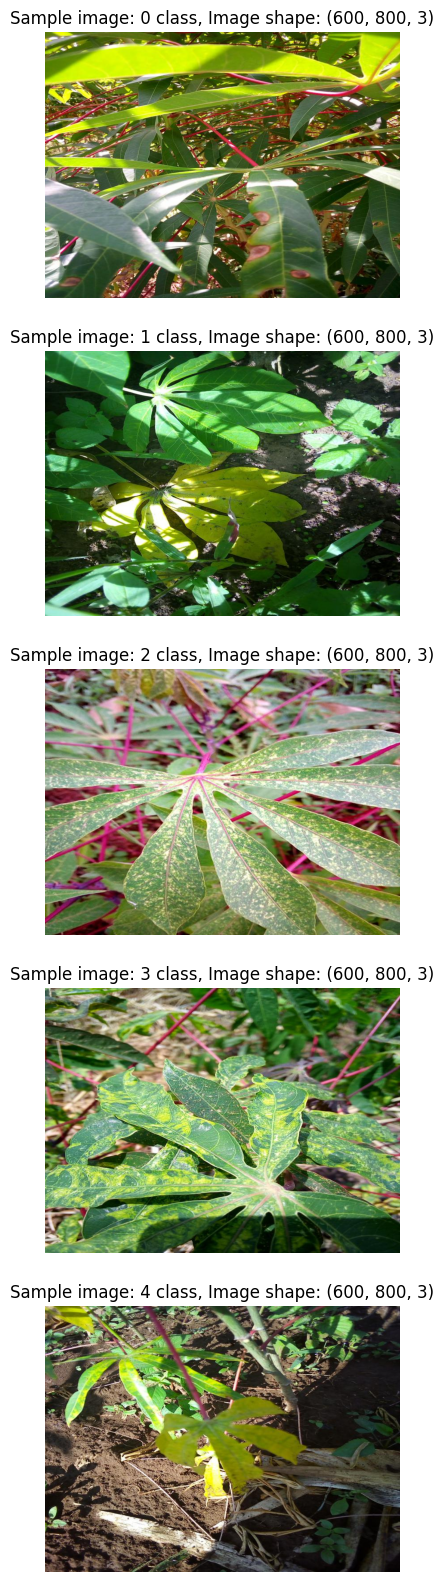

In [12]:
def show_sample_images_of_each_class(df:pd.DataFrame, data_path:str, figsize:tuple):
    class_num = len(df['label'].unique())
    fig = plt.figure(figsize=figsize)
    
    for i in range(class_num):
        sample_data_path = df[df['label']==i]['image_id'].sample().reset_index(drop=True)
        sample_img_path = os.path.join(data_path, sample_data_path.iloc[0])
        sample_img = cv2.imread(sample_img_path)
        sample_img = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)
        
        ax = fig.add_subplot(class_num, 1, i+1)
        plt.imshow(sample_img)
        plt.title('Sample image: {} class, Image shape: {}'.format(i, sample_img.shape))
        plt.axis('off')
    plt.show()
    
show_sample_images_of_each_class(train_df, train_img_path, (50, 20))

In [13]:
from sklearn.model_selection import train_test_split

# create Dataset
class CassavaDataset(Dataset):
    def __init__(self, df:pd.DataFrame, img_path:str, phase:str='train', transform=None):
        self.df = df
        self.img_path = img_path
        self.phase = phase
        self.transform = transform
        
    def __getitem__(self, idx):
        image_id = self.df['image_id'].iloc[idx]
        image_path = os.path.join(self.img_path, image_id)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.transform:
            image = self.transform(image, self.phase)
            
        if self.phase == 'test':
            return image
            
        label = self.df['label'].iloc[idx]
        
        return image, label
    
    def __len__(self):
        return len(self.df)
    
class Transform(object):
    def __init__(self, resize, mean, std):
        self.transform = {
            'train': A.Compose([
                A.Resize(resize, resize),
                A.HorizontalFlip(0.5),
                A.VerticalFlip(0.5),
                A.ShiftScaleRotate(scale_limit=0, p=0.5),
                A.Normalize(mean=mean, std=std),
                ToTensorV2()]),
            'val':A.Compose([
                A.Resize(resize, resize),
                A.Normalize(mean=mean, std=std),
                ToTensorV2()
            ]),
            'test':A.Compose([
                A.Resize(resize, resize),
                A.Normalize(mean=mean, std=std),
                ToTensorV2()
            ]),
        }
    
    def __call__(self, x, phase):
        return self.transform[phase](image=x)['image']

resize = 224
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform = Transform(resize, mean, std)
train, val = train_test_split(train_df, test_size=0.2, random_state=42)
train = train.reset_index(drop=True)
val = val.reset_index(drop=True)
TrainDataset = CassavaDataset(train, train_img_path, 'train', transform)
ValDataset = CassavaDataset(val, train_img_path, 'val', transform)
dl_train = DataLoader(TrainDataset, 16, shuffle=True, num_workers=2)
dl_val = DataLoader(ValDataset, 16, shuffle=True, num_workers=2)
dl_dict = {'train':dl_train, 'val':dl_val}

In [14]:
class BasicConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001)
        self.relu = nn.ReLU(True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)

        return x
    
class InceptionAux(nn.Module):
    def __init__(
        self,
        in_channels,
        num_classes,
        dropout,
    ):
        super().__init__()
        self.pool = nn.AdaptiveAvgPool2d((4, 4))
        self.conv = BasicConv2d(in_channels, 128, kernel_size=1)
        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, num_classes)
        self.dropout = nn.Dropout(p=dropout)
        self.relu = nn.ReLU(True)
        self.flatten = nn.Flatten(1)

    def forward(self, x):
        x = self.pool(x)  # (N, 512 or 528, 4, 4)
        x = self.conv(x)  # (N, 128, 4, 4)
        x = self.flatten(x)  # (N, 128 * 4 * 4)
        x = self.fc1(x)  # (N, 1024)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)  # (N, num_classes)

        return x
    
class Inception(nn.Module):
    def __init__(self,in_channels,ch1x1,ch3x3red,ch3x3,ch5x5red,ch5x5,pool_proj):
        super().__init__()
        self.branch1 = BasicConv2d(in_channels, ch1x1, kernel_size=1)
        self.branch2 = nn.Sequential(
            BasicConv2d(in_channels, ch3x3red, kernel_size=1),
            BasicConv2d(ch3x3red, ch3x3, kernel_size=3, padding=1),
        )
        self.branch3 = nn.Sequential(
            BasicConv2d(in_channels, ch5x5red, kernel_size=1),
            BasicConv2d(ch5x5red, ch5x5, kernel_size=5, padding=2),
        )
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1, ceil_mode=True),
            BasicConv2d(in_channels, pool_proj, kernel_size=1),
        )

    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)

        out = torch.cat([branch1, branch2, branch3, branch4], 1)

        return out
    
class GoogLeNet(nn.Module):
    def __init__(self, num_classes=1000, aux_logits=True, dropout=0.4, dropout_aux=0.7):
        super().__init__()
        self.aux_logits = aux_logits

        self.conv1 = BasicConv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.maxpool1 = nn.MaxPool2d(3, stride=2, ceil_mode=True)
        self.conv2 = BasicConv2d(64, 64, kernel_size=1)
        self.conv3 = BasicConv2d(64, 192, kernel_size=3, padding=1)
        self.maxpool2 = nn.MaxPool2d(3, stride=2, ceil_mode=True)

        self.inception3a = Inception(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = Inception(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(3, stride=2, ceil_mode=True)

        self.inception4a = Inception(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = Inception(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = Inception(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = Inception(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = Inception(528, 256, 160, 320, 32, 128, 128)
        self.maxpool4 = nn.MaxPool2d(3, stride=2, ceil_mode=True)

        self.inception5a = Inception(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = Inception(832, 384, 192, 384, 48, 128, 128)

        if aux_logits:
            self.aux1 = InceptionAux(512, num_classes, dropout=dropout_aux)
            self.aux2 = InceptionAux(528, num_classes, dropout=dropout_aux)
        else:
            self.aux1 = None
            self.aux2 = None

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(p=dropout)
        self.fc = nn.Linear(1024, num_classes)
        self.flatten = nn.Flatten(1)
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, nonlinearity="linear")
                if m.out_features == 1000:
                    nn.init.zeros_(m.bias)  # 出力層は0で初期化する
                else:
                    nn.init.constant_(m.bias, 0.2)
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, nonlinearity="conv2d")

    def forward(self, x):
        x = self.conv1(x)  # (N, 64, 112, 112)
        x = self.maxpool1(x)  # (N, 64, 56, 56)
        x = self.conv2(x)  # (N, 64, 56, 56)
        x = self.conv3(x)  # (N, 192, 56, 56)
        x = self.maxpool2(x)  # (N, 192, 28, 28)
        x = self.inception3a(x)  # (N, 256, 28, 28)
        x = self.inception3b(x)  # (N, 480, 28, 28)
        x = self.maxpool3(x)  # (N, 480, 14, 14)
        x = self.inception4a(x)  # (N, 512, 14, 14)

        aux1 = self.aux1(x) if self.aux_logits and self.training else None

        x = self.inception4b(x)  # (N, 512, 14, 14)
        x = self.inception4c(x)  # (N, 512, 14, 14)
        x = self.inception4d(x)  # (N, 528, 14, 14)

        aux2 = self.aux2(x) if self.aux_logits and self.training else None

        x = self.inception4e(x)  # (N, 832, 14, 14)
        x = self.maxpool4(x)  # (N, 832, 7, 7)

        x = self.inception5a(x)  # (N, 832, 7, 7)
        x = self.inception5b(x)  # (N, 1024, 7, 7)

        x = self.avgpool(x)  # (N, 1024, 1, 1)
        x = self.flatten(x)  # (N, 1024)
        x = self.dropout(x)
        x = self.fc(x)  # (N, 1000)

        if self.aux_logits and self.training:
            return x, aux1, aux2
        else:
            return x
        
model = GoogLeNet(num_classes=5)

In [15]:
from tqdm.notebook import tqdm

def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=50, use_auxiliary=True):
    
    since = time.time()
    best_acc = 0.0
    
    if device == 'cuda':
        model = nn.DataParallel(model)
        torch.backends.cudnn.benchmark = True

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']: # Each epoch has a training and validation phase
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in tqdm(dataloaders[phase]): # Iterate over data
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad() # Zero the parameter gradients

                with torch.set_grad_enabled(phase == 'train'): # Forward. Track history if only in train
                    model = model.to(device)
                    if phase == 'train': # Backward + optimize only if in training phase
                        if use_auxiliary:
                            outputs, aux1, aux2 = model(inputs)
                            loss = criterion(outputs, labels) + 0.3 * criterion(aux1, labels) + 0.3 * criterion(aux2, labels)
                        else:
                            outputs, _, _ = model(inputs)
                            loss = criterion(outputs, labels)
                            
                        _, preds = torch.max(outputs, 1)
                        loss.backward()
                        optimizer.step()
                    
                    if phase == 'val':
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                        _, preds = torch.max(outputs, 1)

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # save the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), 'best_google.net')

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
epochs = 5
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters())
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# train_model(model, dl_dict, criterion, optimizer, device=device, num_epochs=epochs)

In [19]:
model.load_state_dict(torch.load('../input/baseline-googlenet/best_google.net'))
model = model.to(device)
model.eval()

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), strid

In [21]:
test_df = pd.read_csv('../input/cassava-leaf-disease-classification/sample_submission.csv')
test_img_path = '../input/cassava-leaf-disease-classification/test_images'

test_dataset = CassavaDataset(test_df, test_img_path, 'test', transform)
test_dl = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2)

predictions = []

for inputs in test_dl:
    inputs = inputs.to(device)
    outputs = model(inputs)
    _, pred = torch.max(outputs, 1)
    pred = pred.to('cpu')
    predictions.append(pred)
    
test_df['label'] = np.concatenate(predictions)
test_df.to_csv('submission.csv', index=False)